# Example of a Full Data Cleaning and Model Fitting Pipeline

In [208]:
# Import libraries
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# Import preprocessing classes
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Import metrics, models, and CV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, classification_report

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

In [20]:
# Get data
df = pd.read_csv('Data/employee_data.csv')
df.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,221,engineering,NaN,0.932868,4,NaN,low,0.829896,Left,5.0
1,232,support,NaN,NaN,3,NaN,low,0.834544,Employed,2.0
2,184,sales,NaN,0.788830,3,NaN,medium,0.834988,Employed,3.0
3,206,sales,NaN,0.575688,4,NaN,low,0.424764,Employed,2.0
4,249,sales,NaN,0.845217,3,NaN,low,0.779043,Employed,3.0


In [72]:
# Drop duplicates and remove temporary workers
df = df.drop_duplicates()

df = df[df.department != 'temp']

df.department.unique()

array(['engineering', 'support', 'sales', 'IT', 'product', 'marketing',
       'procurement', 'finance', nan, 'management',
       'information_technology', 'admin'], dtype=object)

In [73]:
# Split data into training and test sets
np.random.seed(42)
X = df.drop('status', axis=1)
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11254, 9) (2814, 9) (11254,) (2814,)


In [74]:
# X_train.select_dtypes(include=[np.number])
X_train.dtypes

avg_monthly_hrs        int64
department            object
filed_complaint      float64
last_evaluation      float64
n_projects             int64
recently_promoted    float64
salary                object
satisfaction         float64
tenure               float64
dtype: object

In [113]:
# Create a custom transformer to select columns by their data type
# Only works if receives a pandas DF (not a numpy array)

class SelectColByType(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.select_dtypes(include=[self.dtype])


In [174]:
# Sample custom transformer to run all cleaning and feature engineering steps

class CleanDataAddFeats(BaseEstimator, TransformerMixin):
    def __init__(self, add_feats=True):
        self.add_feats = add_feats
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        # Missing filed_complaint values should be 0
        X['filed_complaint'] = X.filed_complaint.fillna(0)

        # Missing recently_promoted values should be 0
        X['recently_promoted'] = X.recently_promoted.fillna(0)

        # 'IT' should be 'information_technology'
        X.department.replace('IT', 'information_technology', inplace=True)

        # Fill missing categorical department values with 'Missing'
        X['department'].fillna('missing', inplace=True)

        # Create indicator variable if last_evaluation is missing
        X['last_evaluation_missing'] = X.last_evaluation.isnull().astype(int)
        
        # Fill missing values in last_evaluation with 0
        X.last_evaluation.fillna(0, inplace=True)

        if self.add_feats:
            X['underperformer'] = ((X.last_evaluation < 0.6) &
                                   (X.last_evaluation_missing == 0)).astype(int)

            X['unhappy'] = (X.satisfaction < 0.2).astype(int)

            X['overachiever'] = ((X.last_evaluation > 0.8) &
                                 (X.satisfaction > 0.7)).astype(int)

        # Create dummy variables for categorical features
        X = pd.get_dummies(X, columns=['department', 'salary'])
        
        # Return cleaned and augmented dataframe
        return X

In [175]:
# Create a custom transformer to replace a feature value ('IT' with 'information_technology')

class CombineCats(BaseEstimator, TransformerMixin):
    def __init__(self, old_val, new_val):
        self.old_val = old_val
        self.new_val = new_val
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X[X == self.old_val] = self.new_val
        return X

In [189]:
cat_attribs = ['department', 'salary']
bin_attribs = ['filed_complaint', 'recently_promoted']
num_attribs = [col for col in X.columns if col not in (cat_attribs + bin_attribs)]
feat_attribs = ['last_evaluation', 'satisfaction']  # cols feature engineering rely on

num_attribs

['avg_monthly_hrs', 'last_evaluation', 'n_projects', 'satisfaction', 'tenure']

In [206]:
# Create a custom transformer to engineer features

class AddFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):      
        # Create new indicator features        
        # X is a numpy array of only last_evaluation (ix=0) and satisfaction (ix=1)
        last_eval_ix = 0
        satisfaction_ix = 1
        
        last_eval_missing = (X[:, last_eval_ix] == 0).astype(int)
    
        underperformer = ((X[:, last_eval_ix] < 0.6) &
                          (last_eval_missing == 0)).astype(int)
        
        unhappy = (X[:, satisfaction_ix] < 0.2).astype(int)
        
        overachiever = ((X[:, last_eval_ix] > 0.8) &
                        (X[:, satisfaction_ix] > 0.7)).astype(int)
        
        # Return only new features - last_evaluation and satisfaction
        #     are handled in numeric part of pipeline
        return np.c_[last_eval_missing, underperformer, unhappy, overachiever]


In [106]:
X_cols = X_train.columns
list(X_cols)

['avg_monthly_hrs',
 'department',
 'filed_complaint',
 'last_evaluation',
 'n_projects',
 'recently_promoted',
 'salary',
 'satisfaction',
 'tenure']

In [201]:
# Create preprocessing pipelines for numeric and categorical columns

num_proc_pipeline = Pipeline([
    ('num_imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('std_scaler', StandardScaler()),
])

bin_proc_pipeline = Pipeline([
    ('binary_imputer', SimpleImputer(strategy='constant', fill_value=0)),
])

add_feats_pipeline = Pipeline([
    ('tmp_imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('add_feat', AddFeatures()),
])

cat_proc_pipeline = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('combine_cats', CombineCats('IT', 'information_technology')),
    ('one_hot', OneHotEncoder(dtype='int')),
])

preprocessing_pipeline = ColumnTransformer([
    ('process_num', num_proc_pipeline, num_attribs),
    ('process_bins', bin_proc_pipeline, bin_attribs),
    ('add_features', add_feats_pipeline, feat_attribs),
    ('process_cat', cat_proc_pipeline, cat_attribs)],
    remainder='drop')

tmp_X = preprocessing_pipeline.fit_transform(X_train)
print('Transformed X shape: {}'.format(tmp_X.shape))

tmp_X[0, :]

Transformed X shape: (11254, 25)


array([ 0.5557575 , -0.29494481,  0.97241277, -0.199546  ,  0.33776795,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  1.        ,  0.        ])

In [202]:
X_train.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,tenure
10826,229,support,1.0,0.571135,5,NaN,low,0.571765,4.0
8242,215,admin,NaN,0.897595,3,NaN,medium,0.571997,2.0
3742,263,IT,NaN,0.579925,4,NaN,medium,0.549300,3.0
13372,128,management,NaN,0.500546,2,NaN,low,0.352139,3.0
12047,171,sales,NaN,0.648146,2,NaN,medium,0.401360,3.0


In [203]:
# Create columns to re-create DF (to check pipeline worked)
new_feats_cols = ['last_evaluation_missing', 'underperformer', 'unhappy', 'overachiever']

dep = X['department'].fillna('missing').replace('IT', 'information_technology')
department_cols = ['is_' + dep for dep in sorted(dep.unique())]

salary_cols = ['is_' + sal for sal in sorted(X_train['salary'].unique())]

print('Departement Indicators: {}'.format(department_cols))
print('Salary Indicators: {}'.format(salary_cols))

all_cols = num_attribs + bin_attribs + new_feats_cols + department_cols + salary_cols
print(len(all_cols))

Departement Indicators: ['is_admin', 'is_engineering', 'is_finance', 'is_information_technology', 'is_management', 'is_marketing', 'is_missing', 'is_procurement', 'is_product', 'is_sales', 'is_support']
Salary Indicators: ['is_high', 'is_low', 'is_medium']
25


In [204]:
tmp_X_df = pd.DataFrame(tmp_X,
                       columns=all_cols)

tmp_X_df.head()

,avg_monthly_hrs,last_evaluation,n_projects,satisfaction,tenure,filed_complaint,recently_promoted,last_evaluation_missing,underperformer,unhappy,...,is_management,is_marketing,is_missing,is_procurement,is_product,is_sales,is_support,is_high,is_low,is_medium
0,0.555757,-0.294945,0.972413,-0.199546,0.337768,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.274797,0.925429,-0.648131,-0.198618,-1.027375,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.238089,-0.262087,0.162141,-0.289336,-0.344804,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-1.471170,-0.558822,-1.458403,-1.077366,-0.344804,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.608220,-0.007063,-1.458403,-0.880634,-0.344804,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [211]:
# Create full pipelines and fit models

RANDOM_STATE = 42
pipelines = {}

pipelines['logreg'] = Pipeline([('process', preprocessing_pipeline),
                                ('logreg', LogisticRegression(random_state=RANDOM_STATE))])

pipelines['rf'] = Pipeline([('process', preprocessing_pipeline),
                            ('rf', RandomForestClassifier(random_state=RANDOM_STATE))])

pipelines['gb'] = Pipeline([('process', preprocessing_pipeline),
                            ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE))])

# Setup hyperparameter grids for each model: step_name__parameter_name
logreg_hp = {'logreg__C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000],
             'logreg__penalty': ['l1', 'l2']}

rf_hp = {'rf__n_estimators': [100, 200],
         'rf__max_features': ['auto', 'sqrt'],
         'rf__min_samples_leaf': [1, 3, 5, 10]}

gb_hp = {'gb__n_estimators': [100, 200],
         'gb__learning_rate': [0.05, 0.1, 0.2],
         'gb__max_depth': [1, 3, 5]}

hyperparameters = {
    'logreg': logreg_hp,
    'rf': rf_hp,
    'gb': gb_hp
}

In [210]:
# Run GridSearch cross validation to tune model hyperparameters

fitted_models = {}

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=5, n_jobs=-1)
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print(name, 'has been fitted.')

/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


logreg has been fitted.
rf has been fitted.
gb has been fitted.


In [212]:
# Compare model performance

for name, model in fitted_models.items():
    print('Model: {}'.format(name))
    print('CV best score: {}'.format(model.best_score_))
    print('Best hyperparameters: {}'.format(model.best_params_))
    pred = model.predict(X_test)
    print('Test set score: {}'.format(model.score(X_test, y_test)))
    print('Classification Report')
    print(classification_report(y_test, pred))
    print()

Model: logreg
CV best score: 0.8486760263017594
Best hyperparameters: {'logreg__C': 50, 'logreg__penalty': 'l1'}
Test set score: 0.8599857853589197
Classification Report
              precision    recall  f1-score   support

    Employed       0.90      0.92      0.91      2141
        Left       0.73      0.66      0.69       673

   micro avg       0.86      0.86      0.86      2814
   macro avg       0.81      0.79      0.80      2814
weighted avg       0.86      0.86      0.86      2814


Model: rf
CV best score: 0.9777856762040164
Best hyperparameters: {'rf__max_features': 'auto', 'rf__min_samples_leaf': 1, 'rf__n_estimators': 100}
Test set score: 0.9779673063255153
Classification Report
              precision    recall  f1-score   support

    Employed       0.98      0.99      0.99      2141
        Left       0.98      0.93      0.95       673

   micro avg       0.98      0.98      0.98      2814
   macro avg       0.98      0.96      0.97      2814
weighted avg       0.98   

In [231]:
# Get winning model's predictions and predicted probabilities
best_model = fitted_models['rf'].best_estimator_

mod_preds = best_model.predict(X_test)

mod_probs = best_model.predict_proba(X_test)
mod_probs = [p[1] for p in mod_probs]

Area under the ROC curve: 0.9890


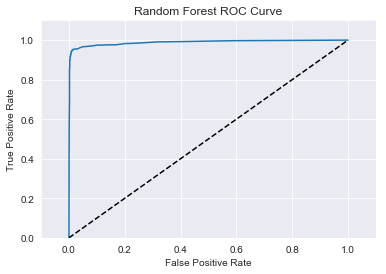

In [230]:
# Plot winning model's test set predictions with ROC Curve

fpr, tpr, thresholds = roc_curve(y_test, mod_probs, pos_label='Left')
auc = roc_auc_score(y_test, mod_probs)

print('Area under the ROC curve: {0:.4f}'.format(auc))

# Plot ROC curve
plt.plot(fpr, tpr);
plt.plot([0, 1], [0, 1], "k--");
plt.axis([-0.1, 1.1, 0, 1.1]);
plt.xlabel("False Positive Rate");
plt.ylabel("True Positive Rate");
plt.title("Random Forest ROC Curve");